In [18]:
import csv
import copy
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

from random import randrange
from scipy import stats

In [2]:
def load_csv(path_to_data):
    with open(path_to_data) as f:
        data = []

        col_names = None

        for row in csv.reader(f):
            if not col_names:
                col_names = row
                col_names[0] = 'age'
            else:
                data.append([float(i) for i in row])

    return col_names, data

def prepare_data(data):
    """
    Use z-score of input feature values
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
    https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)
    """
    feature_vectors = []
    output_classes = []
    
    for entry in data:
        feature_vectors.append(entry[0:-1])
        output_classes.append([entry[-1]])
        
    feature_vectors = np.array(feature_vectors).astype(np.float64)
    feature_vectors = np.apply_along_axis(stats.zscore, 0, feature_vectors)
        
    return feature_vectors, np.array(output_classes), np.hstack((feature_vectors, np.array(output_classes)))

def split_data(all_data, train_perc=0.85, seed=0):
    np.random.seed(seed)
    num_train = math.floor(train_perc * len(all_data))
    
    use_data = copy.deepcopy(all_data)
    
    np.random.shuffle(use_data)
    
    training = []
    while len(training) < num_train:
        sample, use_data = use_data[-1], use_data[:-1]
        
        training.append(sample)
    testing = use_data
    
    training_xs = []
    training_ys = []
    for ind in range(len(training)):
        training_xs.append(training[ind][0:-1])
        training_ys.append(training[ind][-1])
    
    testing_xs = []
    testing_ys = []
    for ind in range(len(testing)):
        testing_xs.append(testing[ind][0:-1])
        testing_ys.append(testing[ind][-1])
        
    training_ys = np.expand_dims(training_ys, 1)
    testing_ys = np.expand_dims(testing_ys, 1)
        
    return ((np.array(training_xs), np.array(training_ys).astype(int)), (np.array(testing_xs), np.array(testing_ys).astype(int)))

In [3]:
activation_functions = ['linear', 'relu', 'tanh', 'sigmoid']
# https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
# https://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://discuss.pytorch.org/t/how-to-create-mlp-model-with-arbitrary-number-of-hidden-layers/13124
class FeedForwardNN(torch.nn.Module):
    def __init__(self, num_layers=2, size_layer=10, activation='linear', final_activation='sigmoid'):
        self._validate_args(num_layers, size_layer, activation, final_activation)
        super(FeedForwardNN, self).__init__()

        self._setup_activation_fns(activation, final_activation)
        
        num_input_features = 13
        num_output_classes = 2
        self._setup_layers(num_layers, size_layer, num_input_features, num_output_classes)
        
    def _validate_args(self, num_layers, size_layer, activation, final_activation):
        assert num_layers >= 2, 'min_layers = 2 (1 for input layer; 1 for output layer)'
        assert size_layer >= 1, 'at least 1 node required per layer'
        assert activation in activation_functions and final_activation in activation_functions, 'only {} are valid actiation functions'.format(activation_functions)
        
    def _setup_activation_fns(self, a, final_activation):
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        
        if a == 'sigmoid':
            self.intermediate_activation = self.sigmoid
        elif a == 'tanh':
            self.intermediate_activation = self.tanh
        elif a == 'relu':
            self.intermediate_activation = self.relu
        elif a == 'linear':
            self.intermediate_activation = lambda x: x
        else:
            raise Exception('intermediate_activation {} not supported'.format(a))
            
        if final_activation == 'sigmoid':
            self.final_activation = self.sigmoid
        elif final_activation == 'tanh':
            self.final_activation = self.tanh
        elif final_activation == 'relu':
            self.final_activation = self.relu
        elif final_activation == 'linear':
            self.final_activation = lambda x: x
        else:
            raise Exception('final_activation {} not supported'.format(a))
                    
    def _setup_layers(self, n, sl, num_in_features, num_out_classes):
        self.hidden_layers = torch.nn.ModuleList()
        
        self.input_layer = torch.nn.Linear(num_in_features, sl)
        for layer_ind in range(n - 2):
            self.hidden_layers.append(torch.nn.Linear(sl, sl))
        self.output_layer = torch.nn.Linear(sl, num_out_classes)
        
    def forward(self, x):
        x = self.intermediate_activation(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = self.intermediate_activation(layer(x))
        
        return self.final_activation(self.output_layer(x))
    
def train_nn(nn, (train_x, train_y), epochs=100, lr=0.0001, verbose=False):
    torch.manual_seed(0)
    converted_train_y = train_y.squeeze().long()
    nn = nn.double()
    optimizer = torch.optim.SGD(nn.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()
    
    epoch_nums = []
    loss_vals = []
    
    for epoch_ind in range(epochs):
        optimizer.zero_grad()
        pred_y = nn(train_x)
        loss = loss_function(pred_y, converted_train_y)
        
        if (epoch_ind+1) % 1000 == 0:
            epoch_nums.append(epoch_ind+1)
            loss_vals.append(loss.item())
        if (epoch_ind+1) % 5000 == 0:
            if verbose:
                print('epoch={} loss={}'.format(epoch_ind+1, loss.item()))
            
        loss.backward()
        optimizer.step()
        
    return epoch_nums, loss_vals
        
def class_prediction_from_model_output(model_output):
    return torch.ByteTensor([pred_tup.max(0)[1].item() for pred_tup in model_output])

def calc_error(labels, predictions):
    predictions = class_prediction_from_model_output(predictions)
    
    num_same = predictions.eq(labels).sum()
    num_diff = len(labels) - num_same
    
    error = 1.0 * num_diff / len(labels)
    
    return error.item(), np.expand_dims(predictions.numpy(), 1)

def plot_xs_ys((xs, ys), (xs_title, ys_title), title):
    plt.scatter(xs, ys, color='blue')
    plt.xlabel(xs_title)
    plt.ylabel(ys_title)
    plt.title(title)
    plt.show()
    
def calc_result_stats((xs, ys, pred_ys)):
    # true negative: healthy and predicted healthy
    # true positive: heart disease and predicted heart disease
    # false positive: healthy and predicted heart disease
    # false negative: heart disease and predicted healthy
    
    tps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 1])
    tns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 0])
    fps = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 0 and pred_ys[ind] == 1])
    fns = np.array([xs[ind] for ind in range(len(xs)) if ys[ind] == 1 and pred_ys[ind] == 0])

    return tps, tns, fps, fns

def plot_data((xs, ys, pred_ys), axis_info):
    tps, tns, fps, fns = calc_result_stats((xs, ys, pred_ys))
    # green/red: healthy/not healthy
    # plus/x: correct prediction / incorrect prediction
    plt.scatter(tps[:, 0], tps[:, 1], label='predicted heart disease (correct)', color='red', marker='+')
    plt.scatter(tns[:, 0], tns[:, 1], label='predicted healthy (correct)', color='green', marker='+')
    plt.scatter(fps[:, 0], fps[:, 1], label='predicted heart disease (wrong)', color='green', marker='x')
    plt.scatter(fns[:, 0], fns[:, 1], label='predicted healthy (wrong)', color='red', marker='x')
        
    plt.xlabel('{} ({})'.format(axis_info[0][1], axis_info[0][2]))
    plt.ylabel('{} ({})'.format(axis_info[1][1], axis_info[1][2]))
    plt.title('{} vs. {}'.format(axis_info[1][1], axis_info[0][1]))
    plt.legend()
    plt.show()
    
def plot_interesting((all_xs, all_ys, all_pred_ys)):
    interesting_inds = [0, 3, 4, 7] # age, resting blood pressure, cholesterol, max heart rate
    adjusted_names = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Max Heart Rate']
    units = ['years', 'mmHg', 'mg/dl', 'bpm']

    axis_info = [(ind, name, units) for ind, name, units in zip(interesting_inds, adjusted_names, units)]

    for ind0, dim0 in enumerate(interesting_inds):
        for ind1, dim1 in enumerate(interesting_inds):
            if ind0 == ind1:
                continue
            dim0_vals = np.expand_dims(all_xs[:, dim0], 1)
            dim1_vals = np.expand_dims(all_xs[:, dim1], 1)

            xs = np.hstack((dim0_vals, dim1_vals))

            plot_data((xs, all_ys, all_pred_ys), [axis_info[ind0], axis_info[ind1]])

def report_results((all_xs, all_ys, all_ys_pred)):
    tps, tns, fps, fns = calc_result_stats((all_xs, all_ys, all_ys_pred))
    print('true positives (heart disease and predicted heart disease) = {}'.format(len(tps)))
    print('true negatives (healthy and predicted healthy) = {}'.format(len(tns)))
    print('false positives (healthy and predicted heart disease) = {}'.format(len(fps)))
    print('false negatives (heart disease and predicted healthy) = {}'.format(len(fns)))
    plot_interesting((all_xs, all_ys, all_ys_pred))

In [9]:
names, data_points = load_csv('../data/orig_raw.csv')
all_xs, all_ys, adjusted_data = prepare_data(data_points)
training, testing = split_data(adjusted_data, train_perc=0.90)
training = torch.from_numpy(training[0]), torch.from_numpy(training[1])
testing = torch.from_numpy(testing[0]), torch.from_numpy(testing[1])
print('{} training samples'.format(len(training[0])))
print('{} testing samples'.format(len(testing[0])))

_, data_points = load_csv('../data/orig_raw.csv')
all_xs_orig_vals = np.array(data_points)[:, range(13)]

272 training samples
31 testing samples


In [11]:
def do_config(config, training_data, testing_data, all_xs_orig_vals):
    num_layers, size_layer, epochs, lr = config['num_layers'], config['size_layer'], config['epochs'], config['lr']
    ffnn = FeedForwardNN(num_layers=num_layers, size_layer=size_layer, activation='relu', final_activation='sigmoid')
    epoch_nums, loss_vals = train_nn(ffnn, training_data, epochs=epochs, lr=lr)
    
    plot_xs_ys((epoch_nums, loss_vals), ('epoch number', 'loss value'), 'Loss vs. Epoch Number: layers={} size_layer={}'.format(num_layers, size_layer))
    print('final_loss={}'.format(loss_vals[-1]))
    
    pred_test_y = ffnn(testing_data[0])
    pred_train_y = ffnn(training_data[0])
    training_error, training_pred_ys = calc_error(training_data[1].squeeze(), pred_train_y)
    testing_error, testing_pred_ys = calc_error(testing_data[1].squeeze(), pred_test_y)
    all_pred_ys = np.vstack((training_pred_ys, testing_pred_ys))
    all_ys = np.vstack((training_data[1], testing_data[1]))
    all_xs = np.vstack((training_data[0], testing_data[0]))
    print('layers={} size_layer={} epochs={} lr={}'.format(num_layers, size_layer, epochs, lr))
    print('training_error={} testing_error={}'.format(training_error, testing_error))
    
    print('-----results on entire dataset-----')
    report_results((all_xs_orig_vals, all_ys, all_pred_ys))

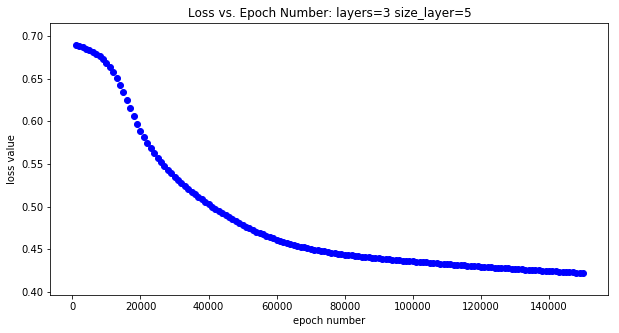

final_loss=0.421966620417
layers=3 size_layer=5 epochs=150000 lr=0.001
training_error=0.0955882370472 testing_error=0.129032254219
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 154
true negatives (healthy and predicted healthy) = 119
false positives (healthy and predicted heart disease) = 19
false negatives (heart disease and predicted healthy) = 11


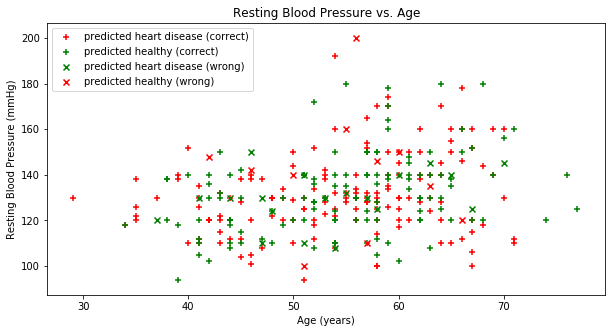

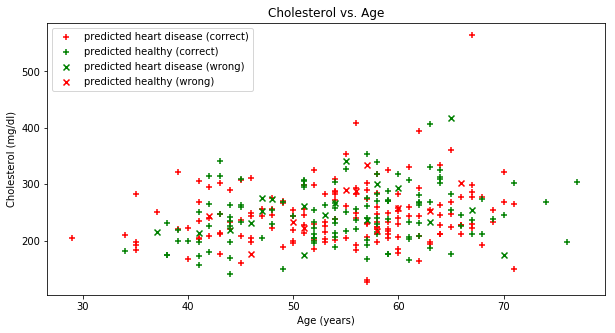

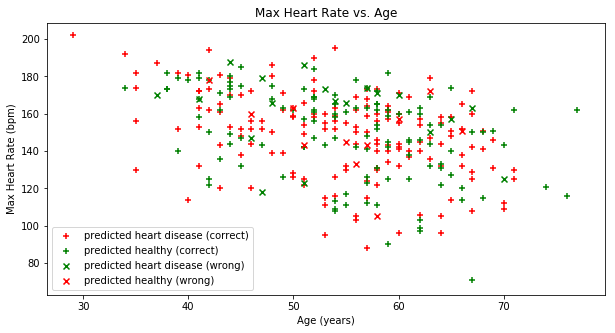

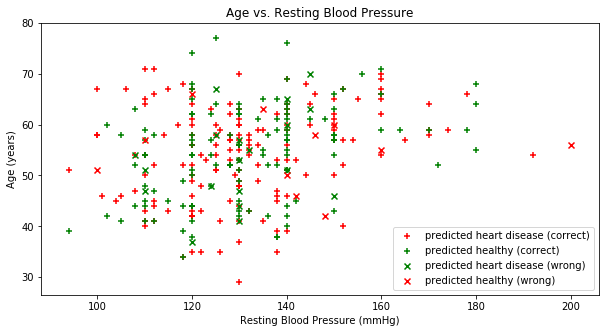

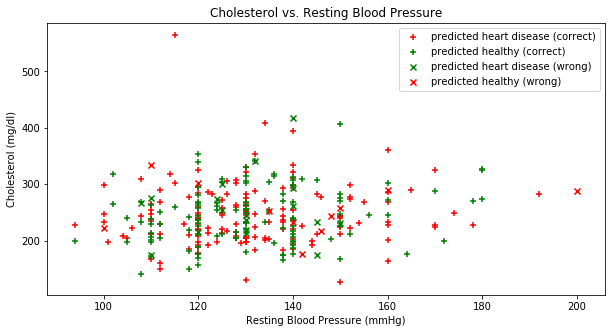

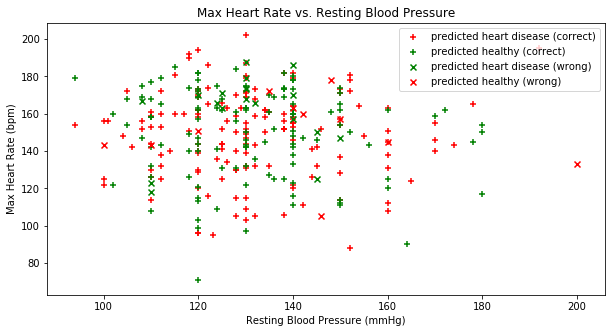

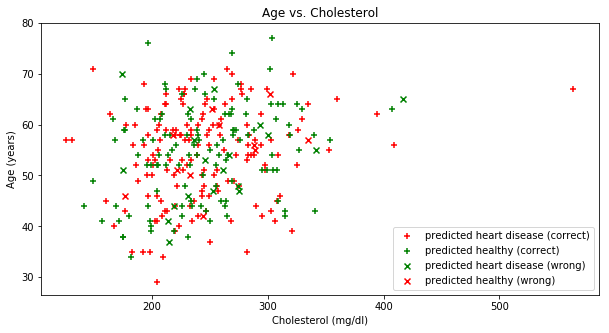

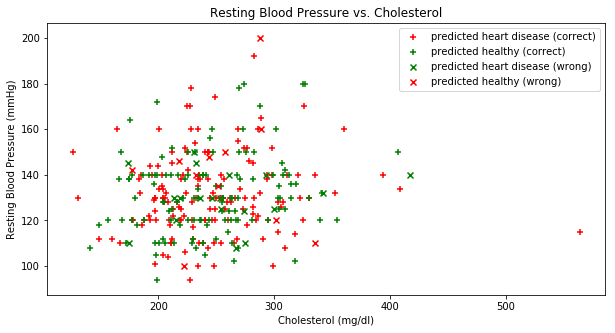

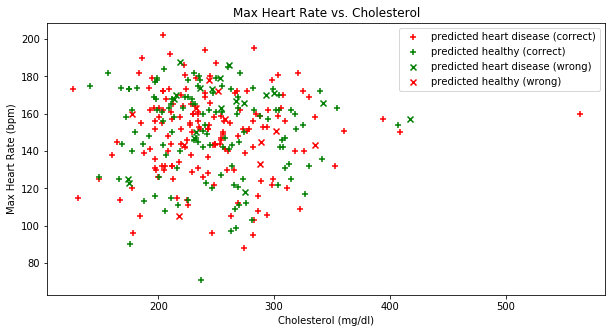

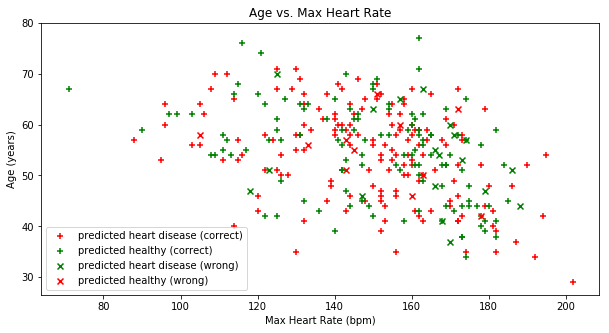

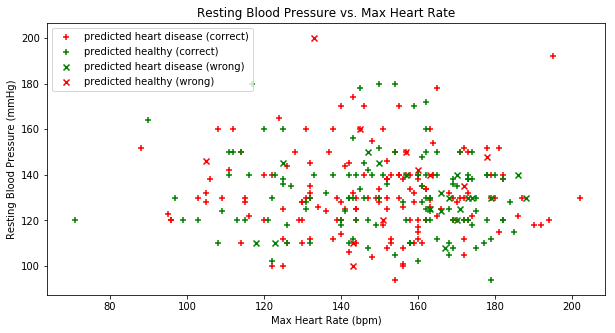

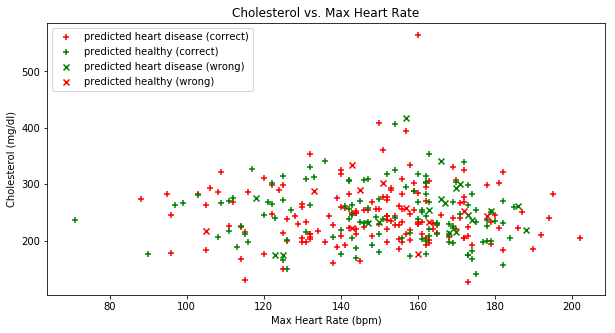

In [20]:
config = {
    'num_layers': 3,
    'size_layer': 5,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

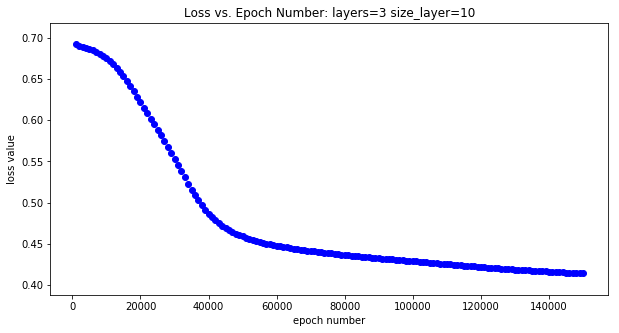

final_loss=0.414243441442
layers=3 size_layer=10 epochs=150000 lr=0.001
training_error=0.088235296309 testing_error=0.161290317774
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 119
false positives (healthy and predicted heart disease) = 19
false negatives (heart disease and predicted healthy) = 10


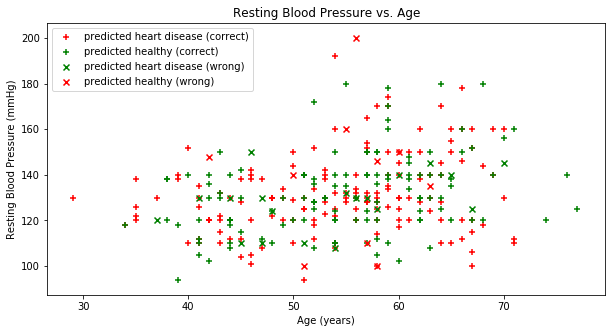

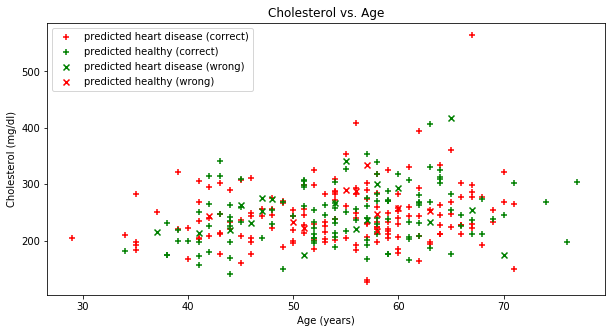

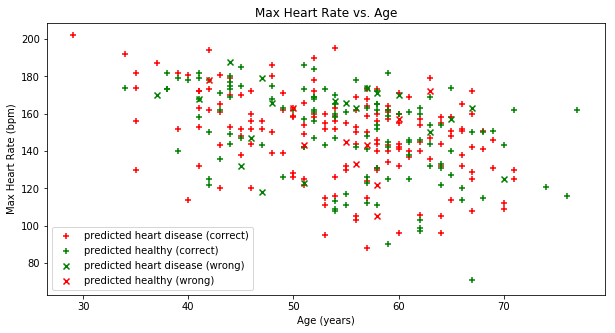

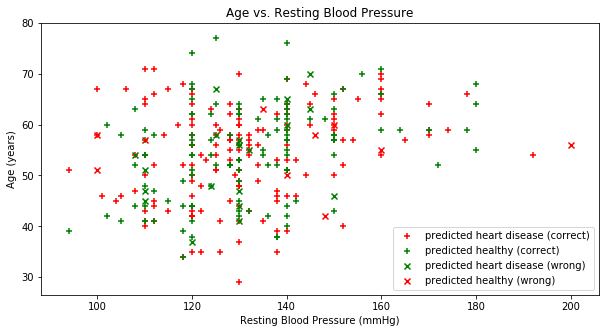

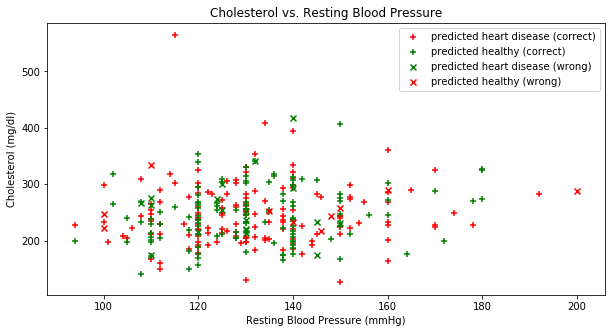

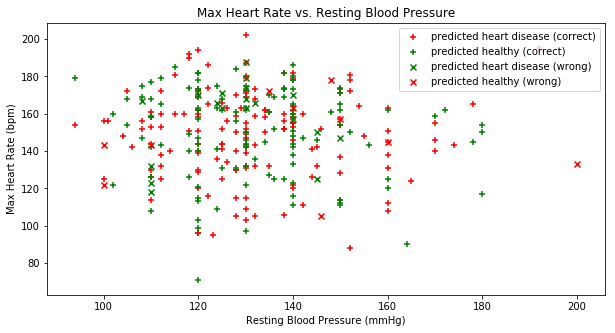

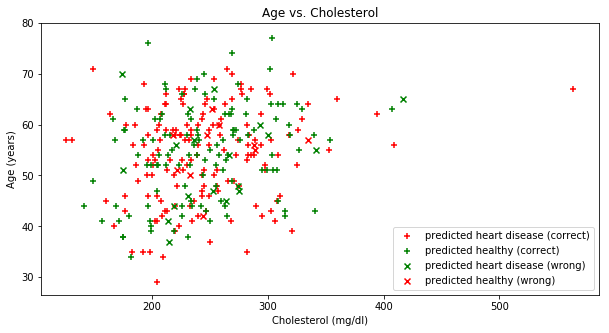

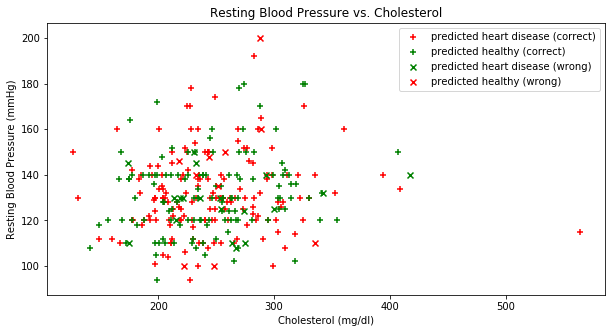

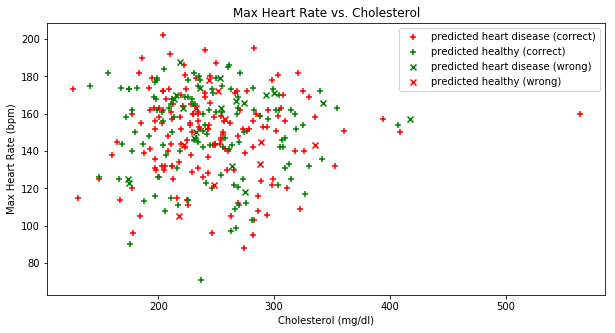

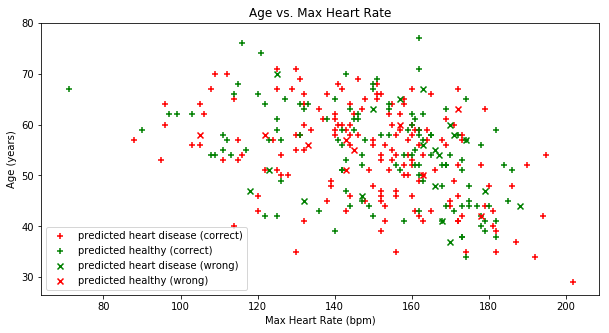

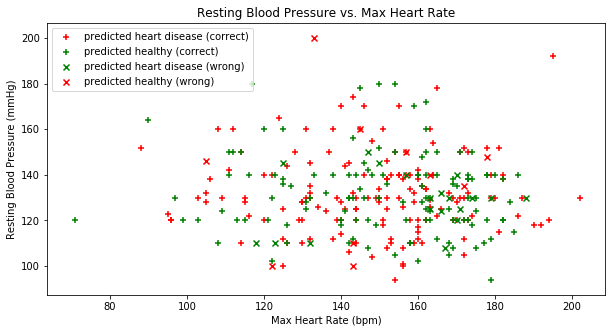

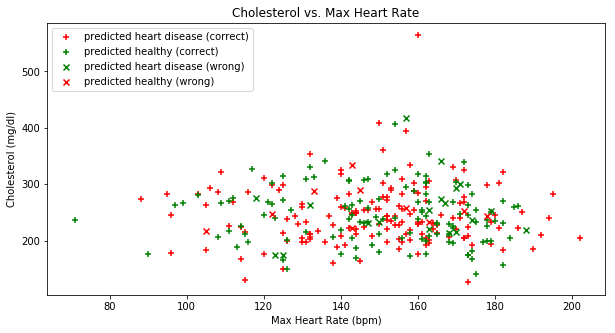

In [22]:
config = {
    'num_layers': 3,
    'size_layer': 10,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

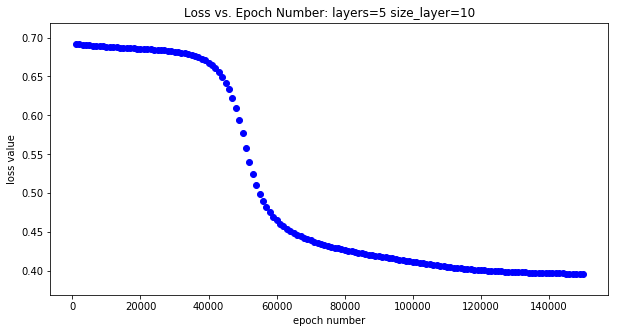

final_loss=0.396473464721
layers=5 size_layer=10 epochs=150000 lr=0.001
training_error=0.0808823555708 testing_error=0.129032254219
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 122
false positives (healthy and predicted heart disease) = 16
false negatives (heart disease and predicted healthy) = 10


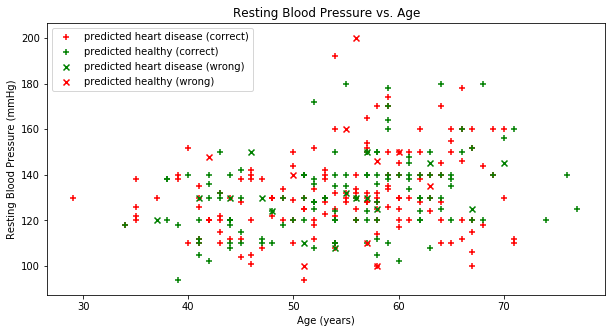

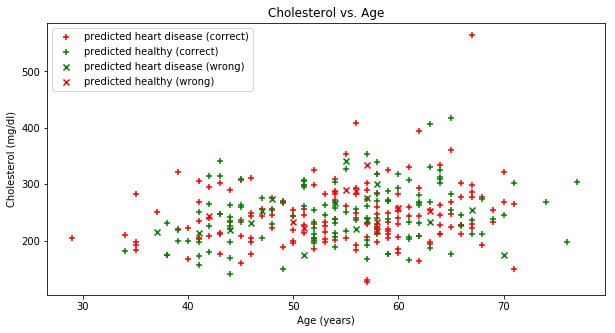

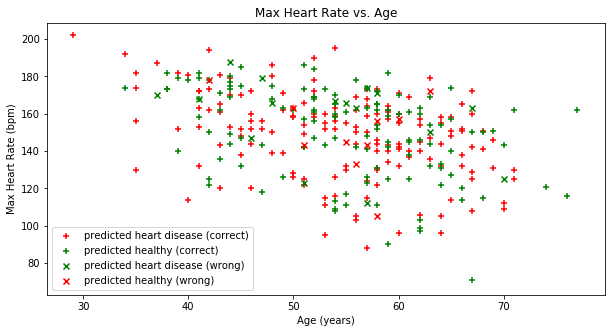

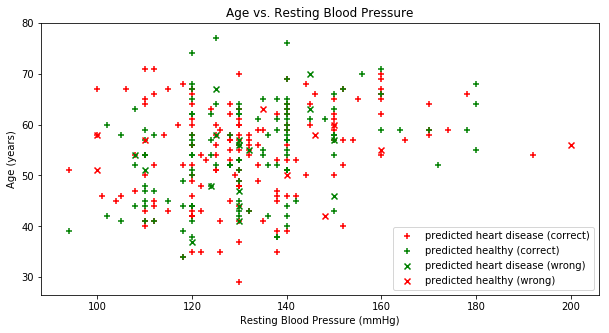

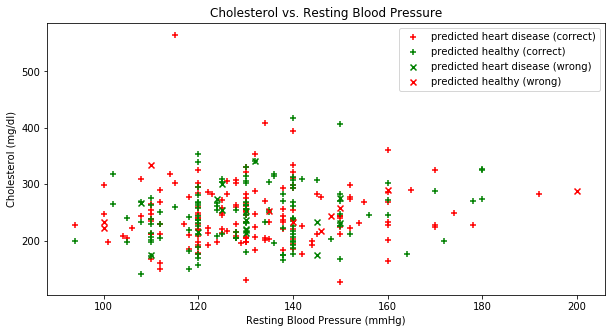

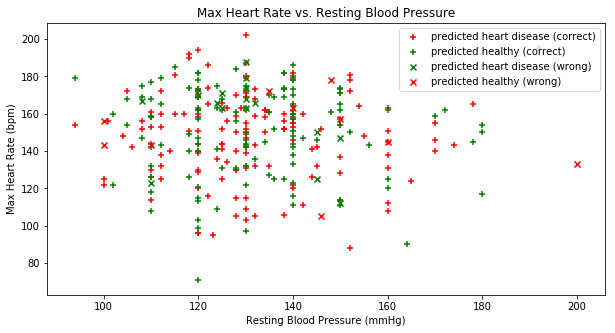

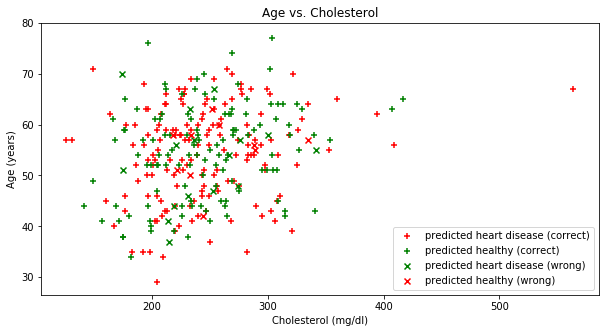

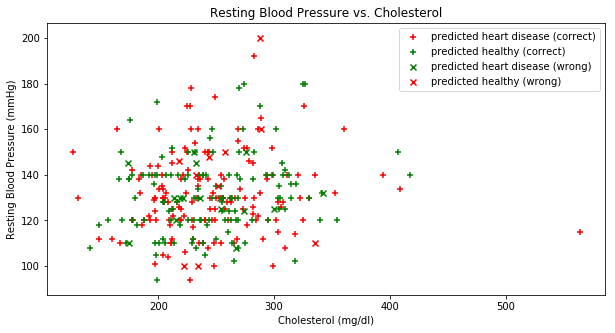

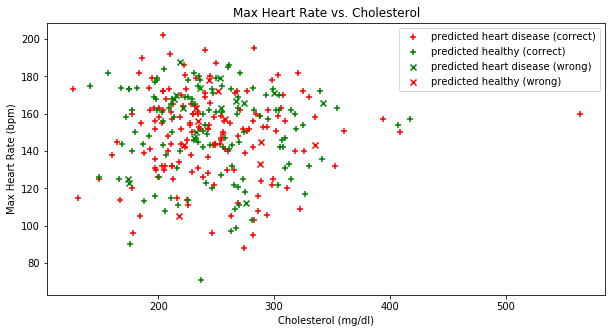

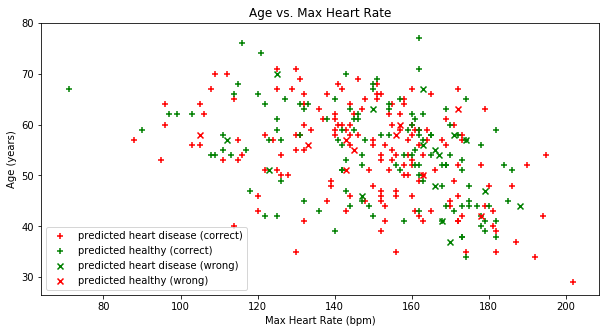

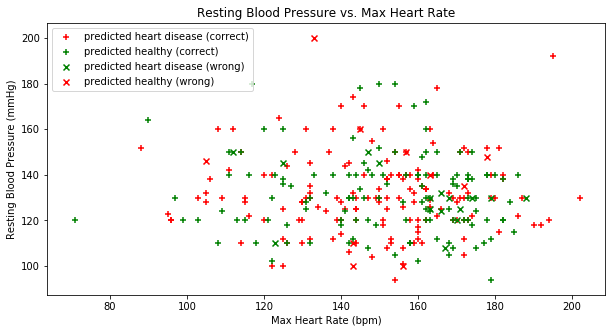

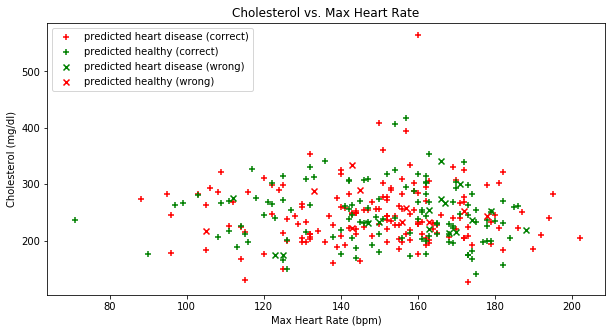

In [23]:
config = {
    'num_layers': 5,
    'size_layer': 10,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

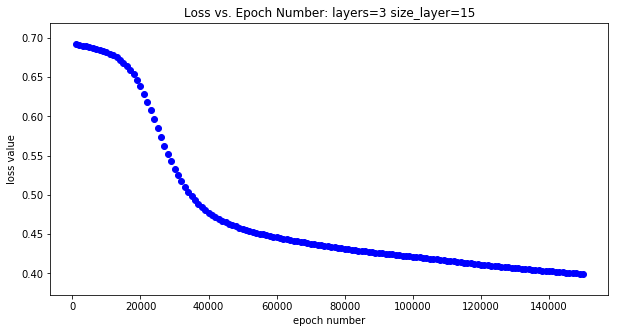

final_loss=0.39947240983
layers=3 size_layer=15 epochs=150000 lr=0.001
training_error=0.0735294148326 testing_error=0.129032254219
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 156
true negatives (healthy and predicted healthy) = 123
false positives (healthy and predicted heart disease) = 15
false negatives (heart disease and predicted healthy) = 9


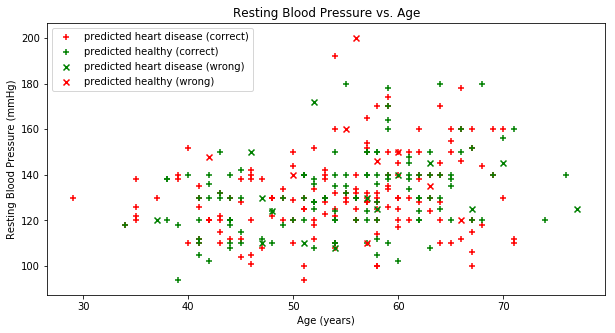

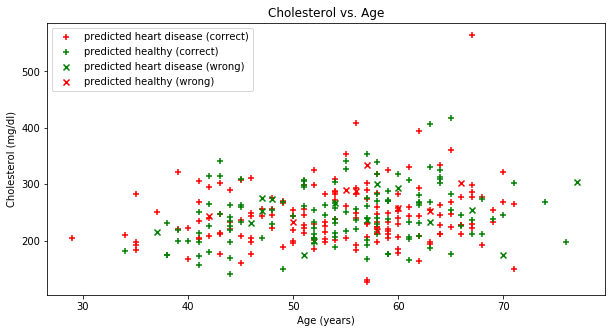

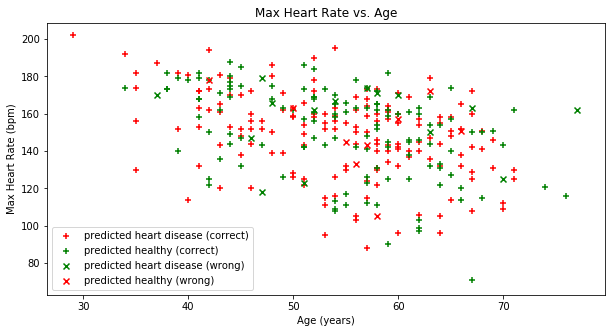

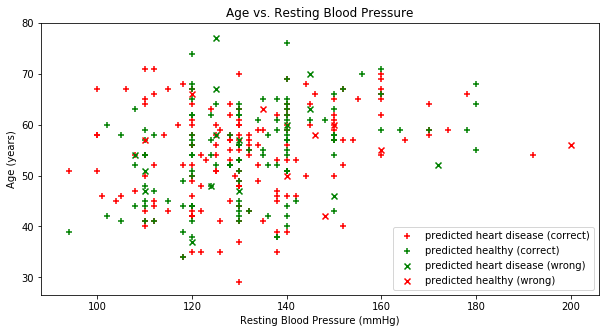

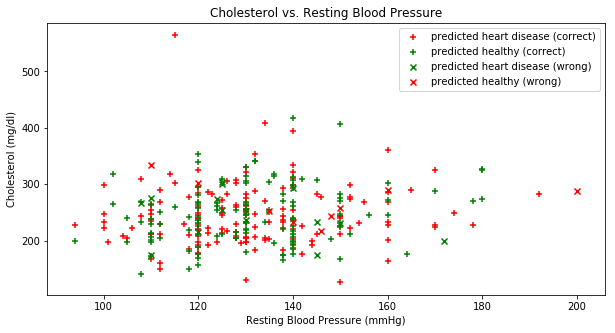

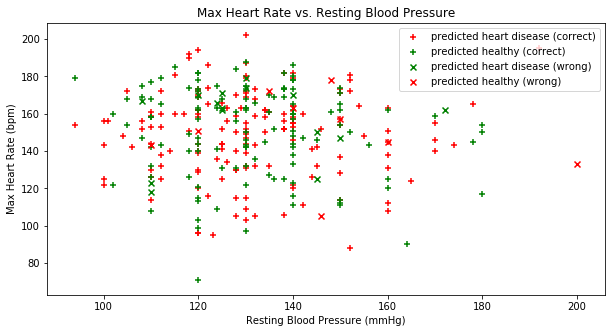

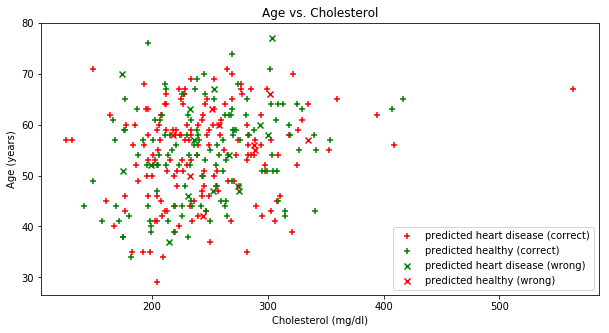

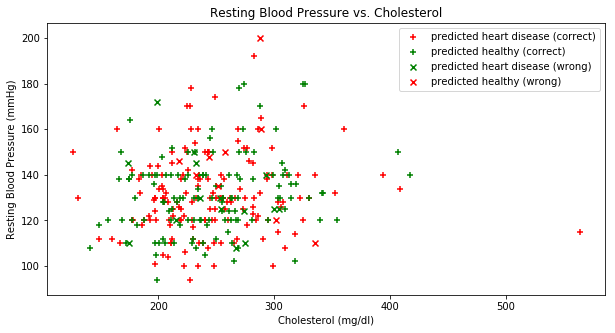

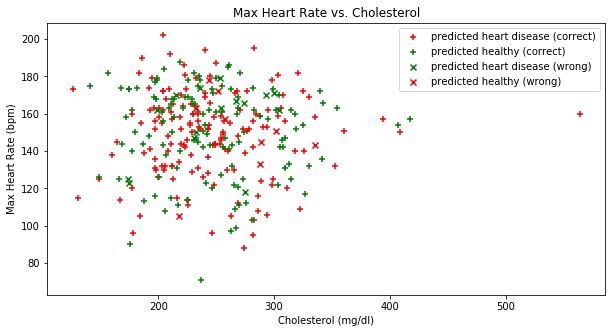

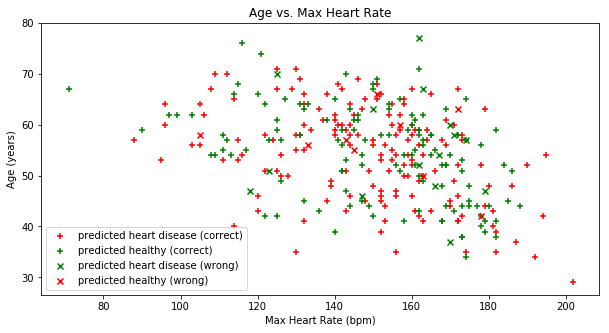

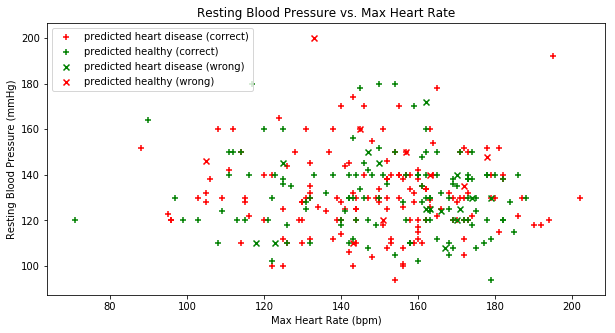

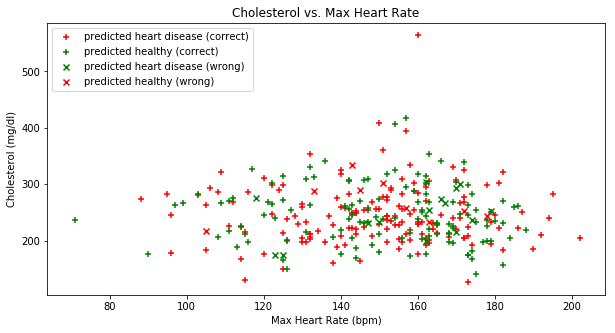

In [25]:
config = {
    'num_layers': 3,
    'size_layer': 15,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

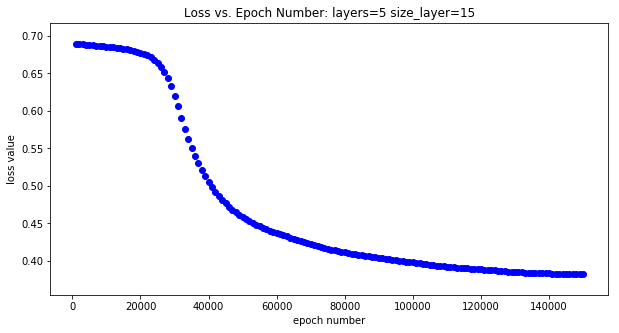

final_loss=0.382279962287
layers=5 size_layer=15 epochs=150000 lr=0.001
training_error=0.0661764740944 testing_error=0.161290317774
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 125
false positives (healthy and predicted heart disease) = 13
false negatives (heart disease and predicted healthy) = 10


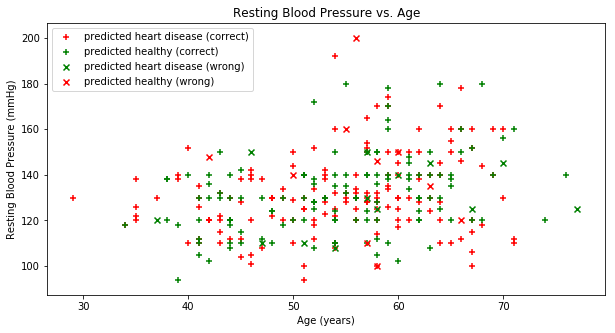

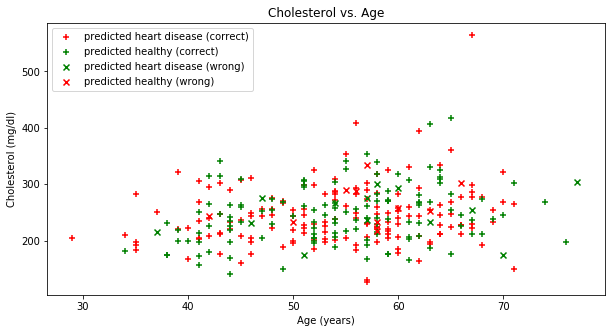

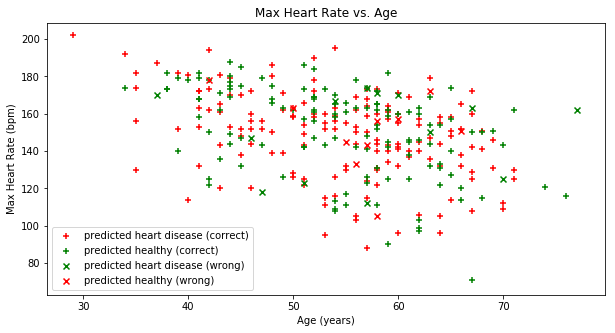

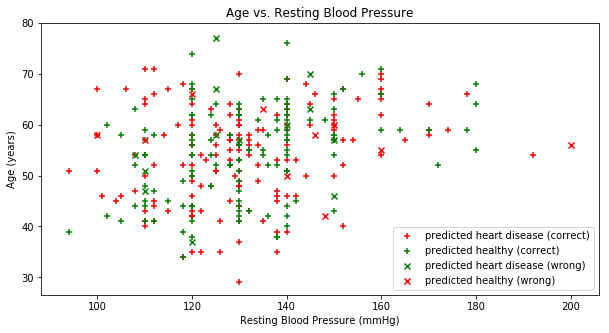

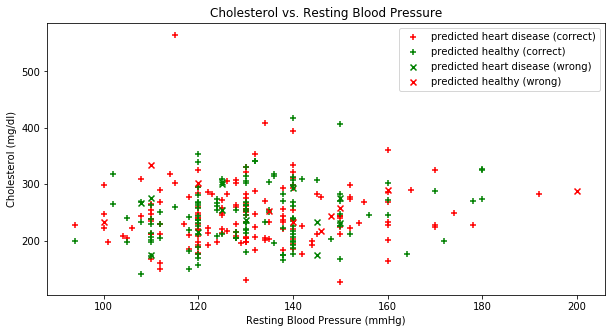

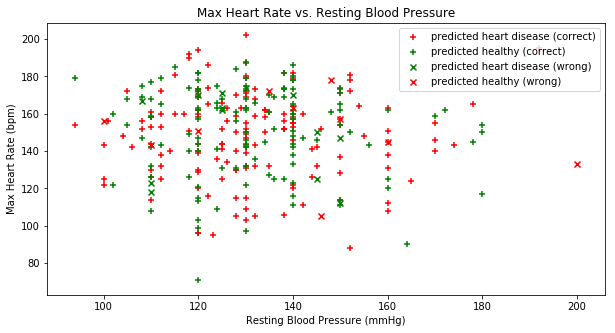

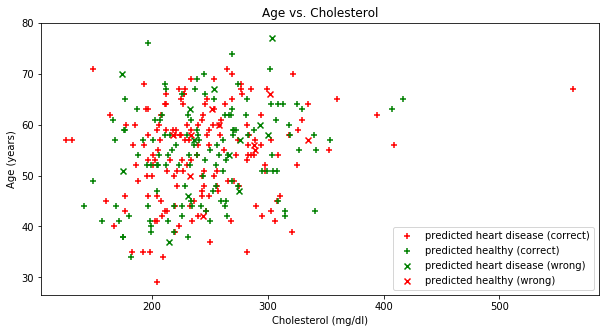

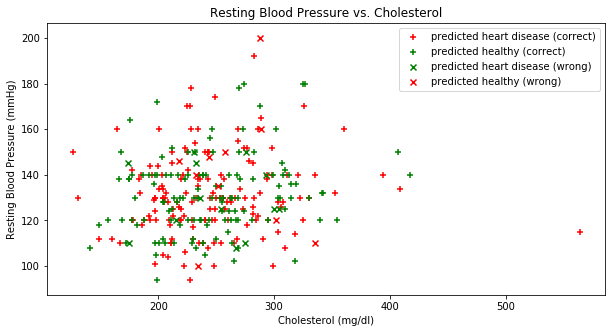

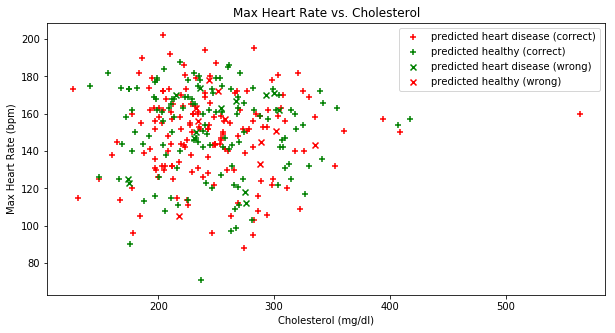

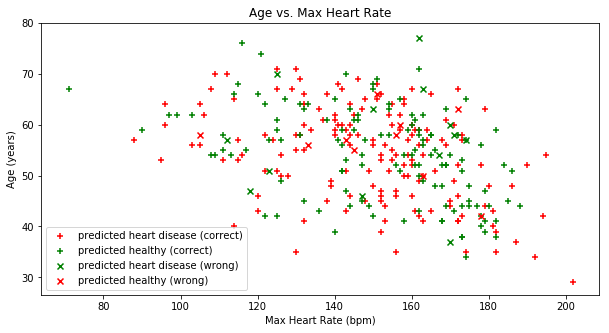

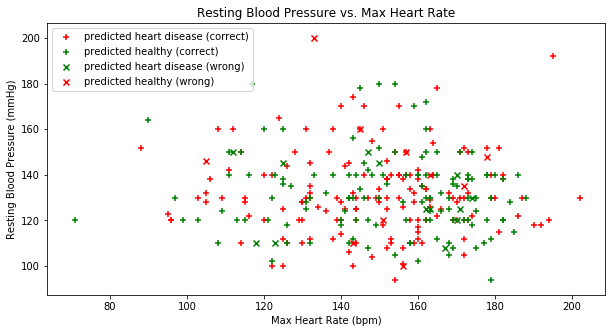

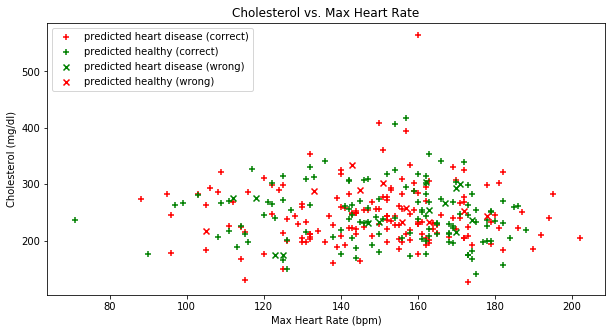

In [26]:
config = {
    'num_layers': 5,
    'size_layer': 15,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

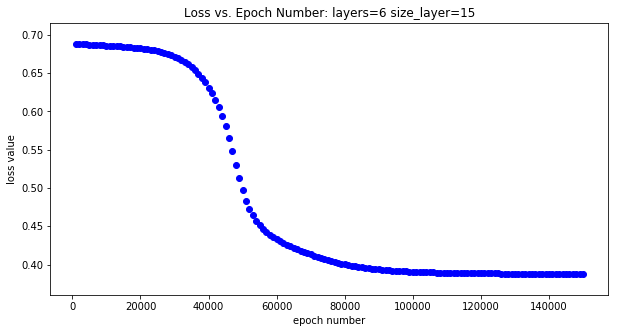

final_loss=0.387661927169
layers=6 size_layer=15 epochs=150000 lr=0.001
training_error=0.0735294148326 testing_error=0.161290317774
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 123
false positives (healthy and predicted heart disease) = 15
false negatives (heart disease and predicted healthy) = 10


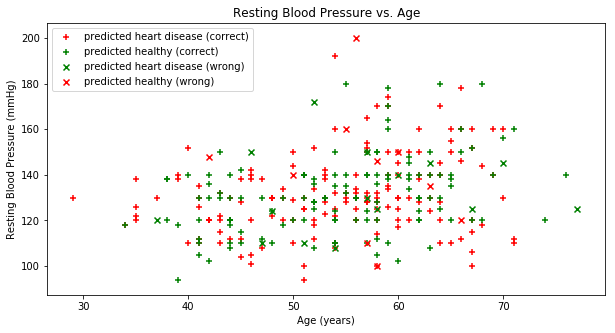

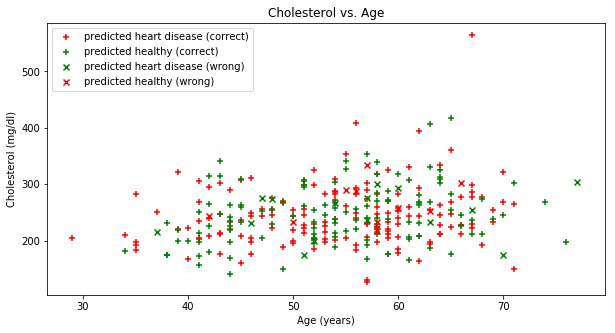

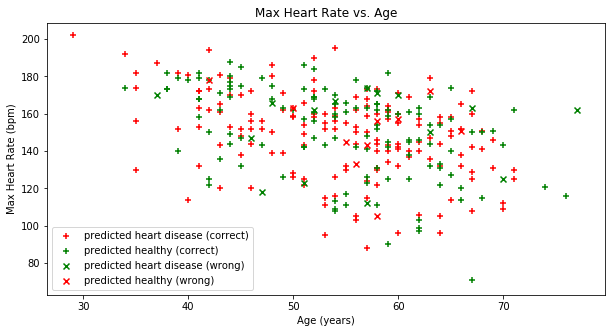

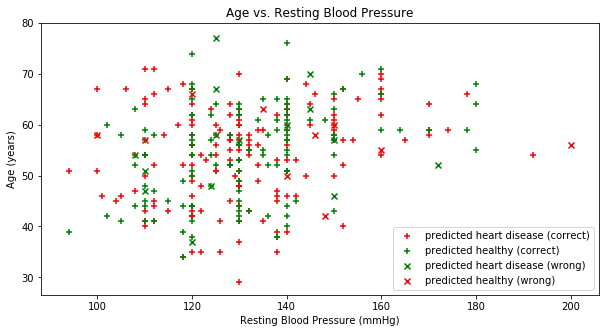

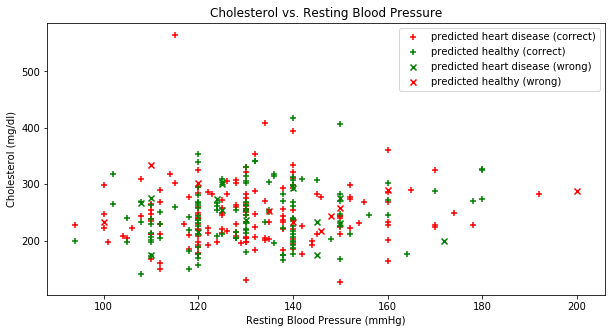

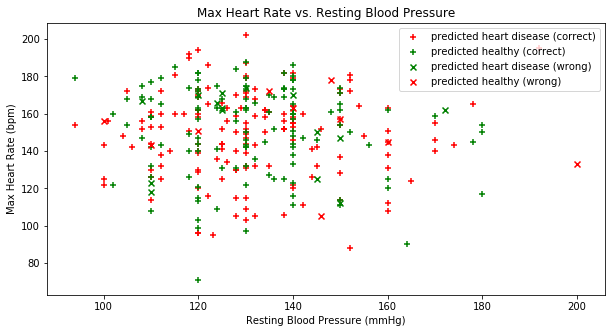

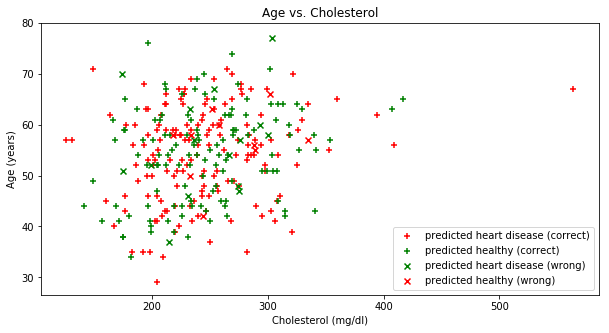

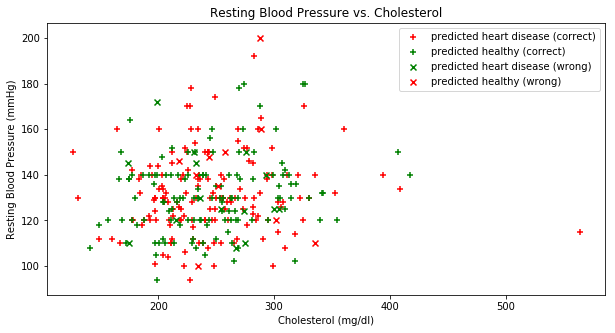

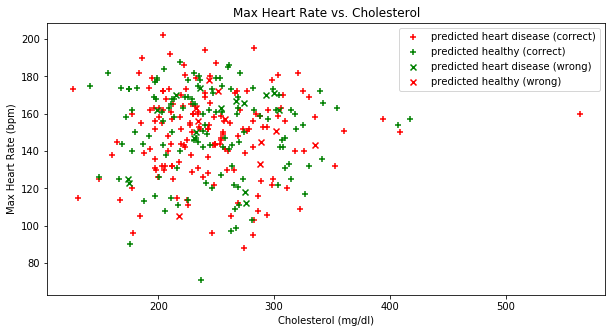

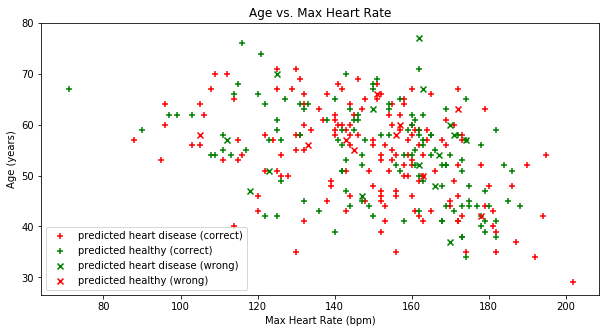

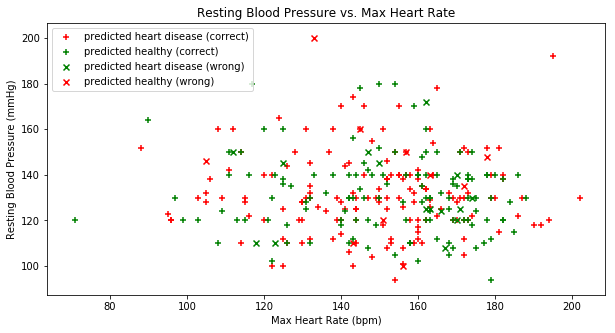

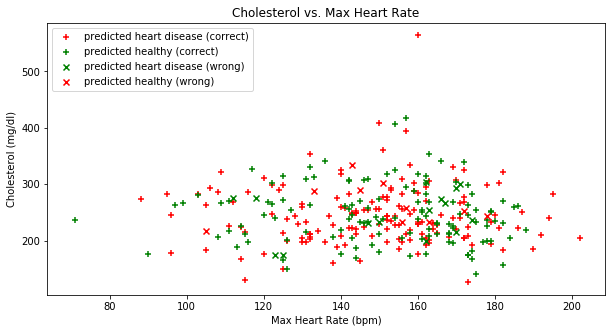

In [28]:
config = {
    'num_layers': 6,
    'size_layer': 15,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

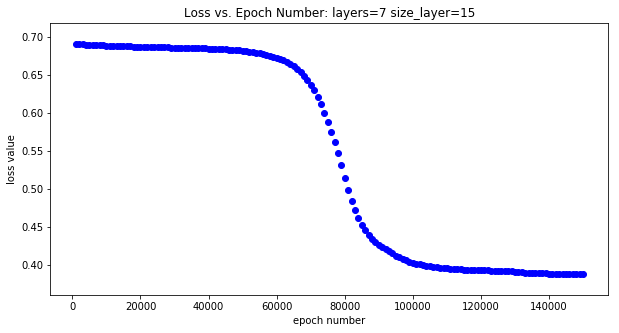

final_loss=0.388246328166
layers=7 size_layer=15 epochs=150000 lr=0.001
training_error=0.0735294148326 testing_error=0.129032254219
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 124
false positives (healthy and predicted heart disease) = 14
false negatives (heart disease and predicted healthy) = 10


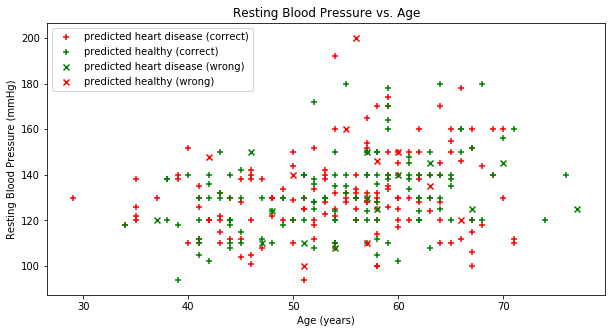

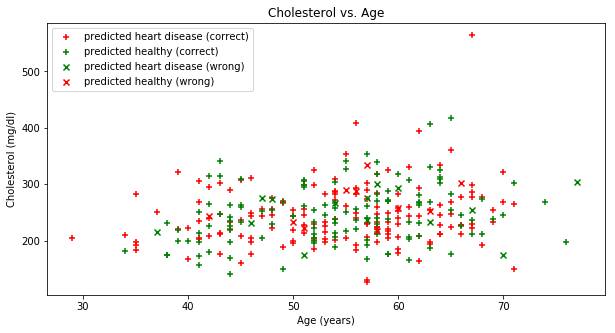

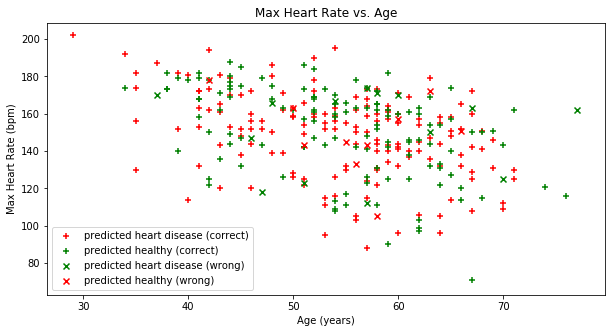

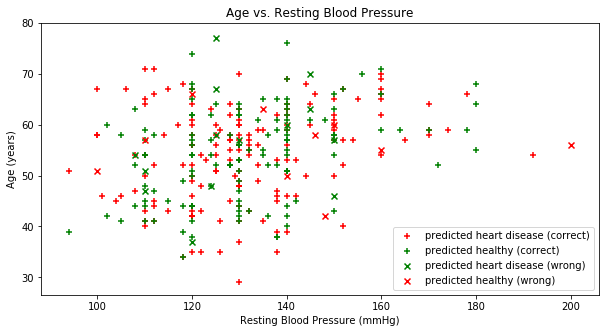

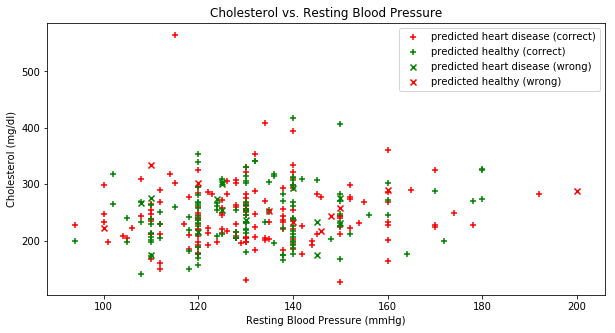

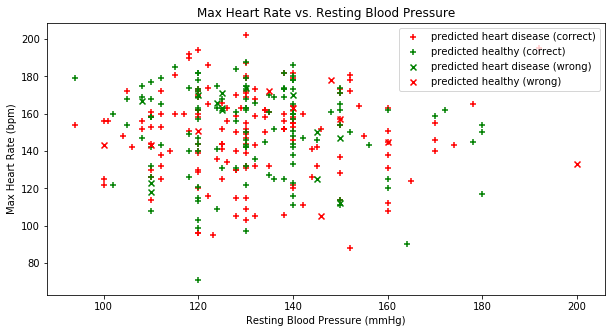

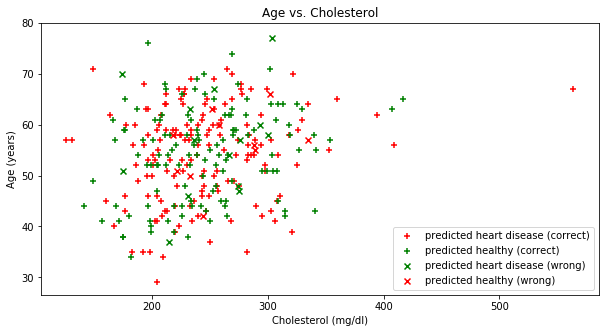

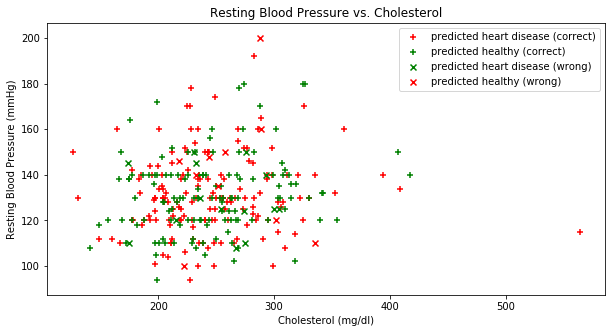

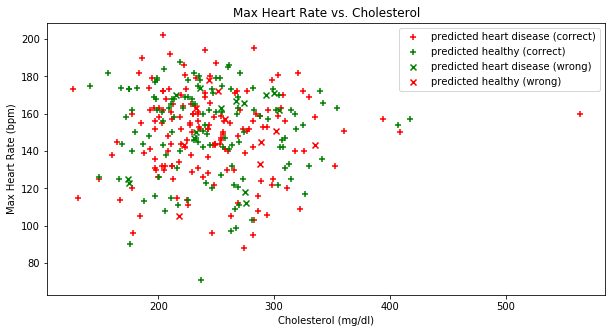

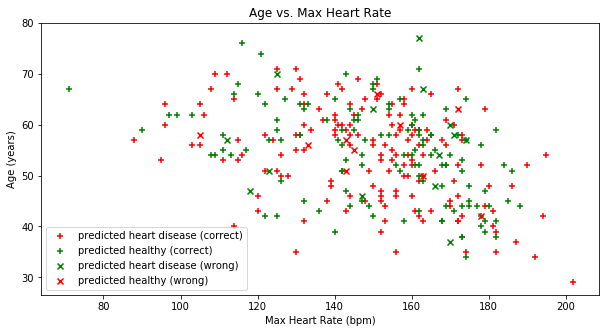

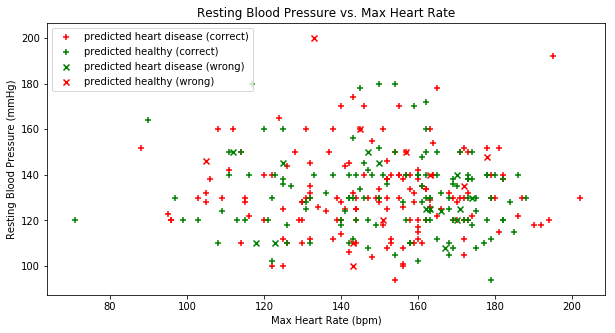

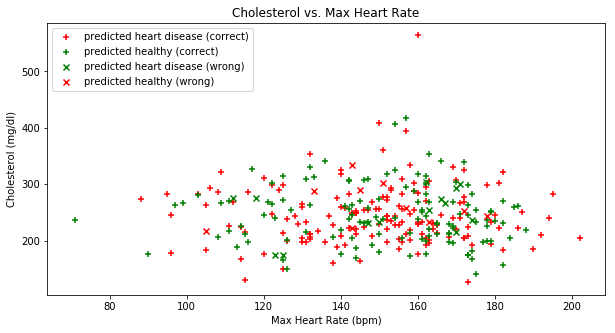

In [29]:
config = {
    'num_layers': 7,
    'size_layer': 15,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)

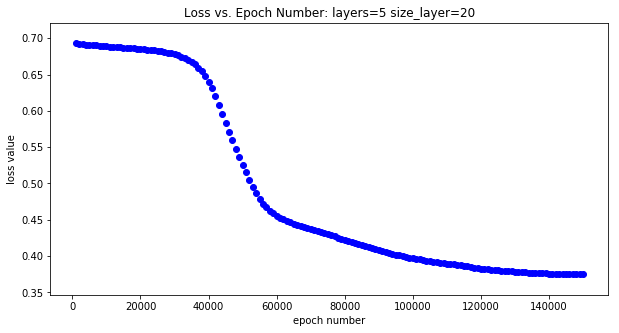

final_loss=0.374650304837
layers=5 size_layer=20 epochs=150000 lr=0.001
training_error=0.0588235296309 testing_error=0.129032254219
-----results on entire dataset-----
true positives (heart disease and predicted heart disease) = 155
true negatives (healthy and predicted healthy) = 128
false positives (healthy and predicted heart disease) = 10
false negatives (heart disease and predicted healthy) = 10


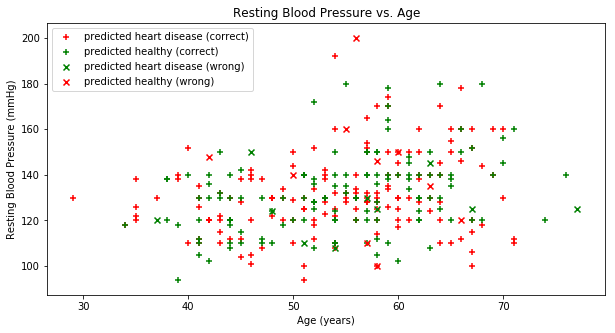

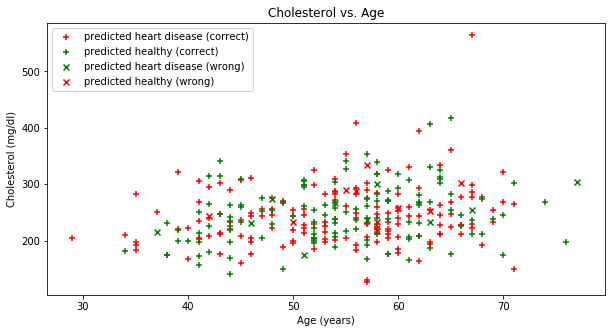

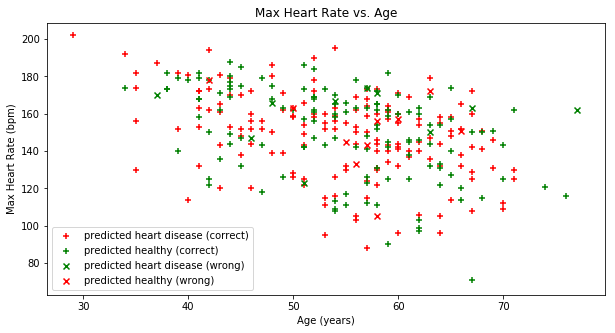

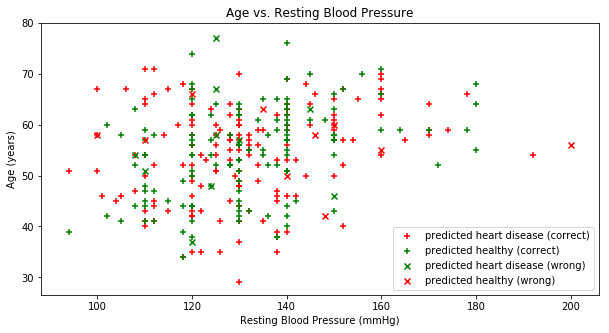

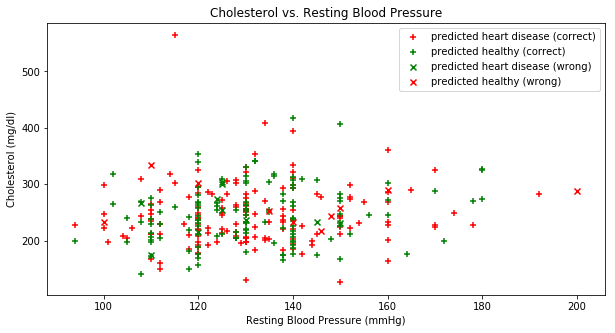

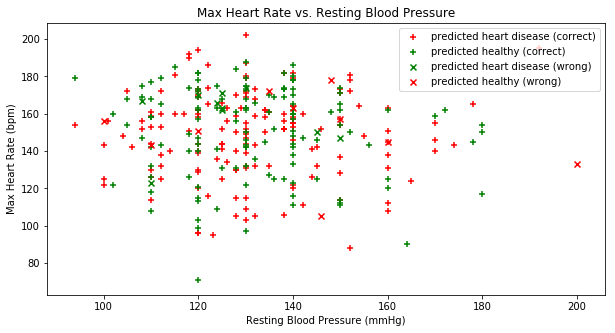

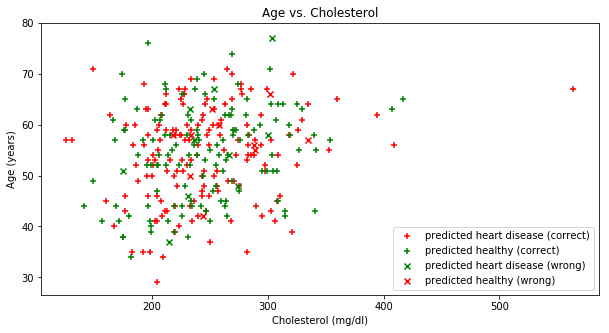

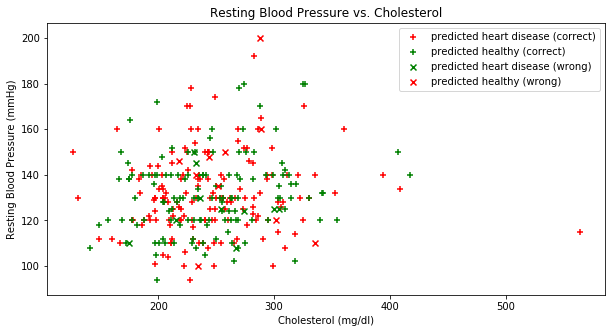

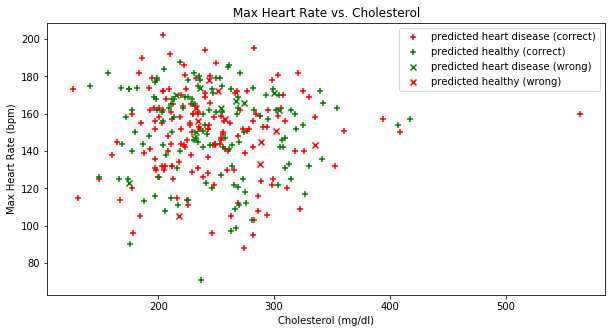

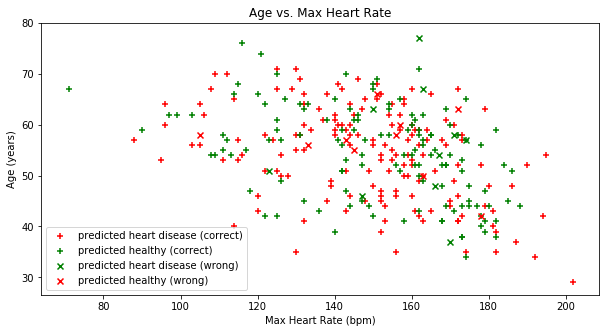

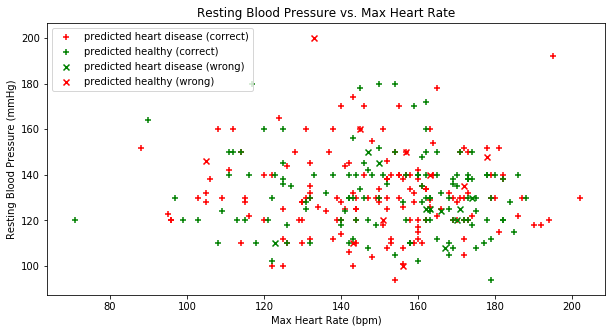

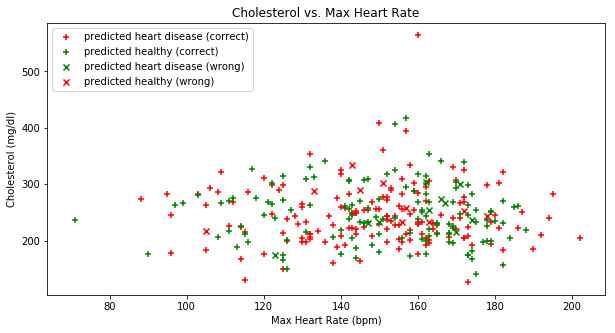

In [31]:
config = {
    'num_layers': 5,
    'size_layer': 20,
    'epochs': 150000,
    'lr': 0.001
}
do_config(config, copy.deepcopy(training), copy.deepcopy(testing), all_xs_orig_vals)